# Defect Creation

Defects are a typical part of nearly all crystals, yet we have not observed any in the simulations of the p2 crystal. This notebook introduces defects into the p2 crystals to see how the crystal reacts. The defect we are interested in is a line defect, which runs along one of the crystal axes.

In [1]:
# Import required modules
from sdrun.initialise import initialise_snapshot, init_from_crystal 
from sdrun.simulation import production, equilibrate
from sdrun.params import SimulationParams as RunParams
from sdrun.crystals import TrimerP2
from sdanalysis.figures import configuration
from sdanalysis.frame import HoomdFrame

import numpy as np
from hoomd.data import make_snapshot
import hoomd

from bokeh.plotting import show, output_notebook
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

To create the defects we are going to be removing molecules from the crystal strucutre, introducing a gap between layers which is effectively two line defects in the crystal structure. The function below does the work of removing a molecule from the cofiguration.

In [2]:
def remove_molecule(snapshot, index: int):
    """Remove an arbitratry molecule from the simulation.
    
    This also ensures a valid configuration once the molecule has been removed.
    """
    mask = snapshot.particles.body != index
    if sum(mask) == snapshot.particles.N:
        print("Index not in snapshot")
        return snapshot
    new_snapshot = make_snapshot(snapshot.particles.N - 3, snapshot.box, snapshot.particles.types, snapshot.pairs.types)
    for attr in ["position", "orientation", "acceleration", "image", "mass", "moment_inertia", "typeid"]:
        getattr(new_snapshot.particles, attr)[:] = getattr(snapshot.particles, attr)[mask]
    body_mask = snapshot.particles.body != max(snapshot.particles.body)
    new_snapshot.particles.body[:] = snapshot.particles.body[body_mask]
    return new_snapshot

For the simulation I am using a pressure of 1.00 with a temperature of 0.40 which is just above our current estimate of the melting point of 0.36. The crystal structure is the p2 structure which appears to be the most stable of the three crystals of this molecule. I am using cell dimensions of 30 x 42 which is the standard number of particles I have been using in the rest of my simulations.

In [3]:
run_params = RunParams(
    temperature=0.40,
    pressure=1.00,
    crystal=TrimerP2(),
    num_steps=1000,
    cell_dimensions=(30, 42, 1),
    hoomd_args='--notice-level=0',
)

In [4]:
# Create a crystal structure
init_snapshot = init_from_crystal(run_params)
show(configuration.plot_frame(HoomdFrame(init_snapshot)))

The starting crystal structure I am using. I have kept the tilt of the unit cell, since I am not currently interested in a quantitative measure of the structure.

## Helper functions

To assist in the creation of the defects I am going to define a collection of helper functions. These functions will assist in the programatic creation of the defects.

In [5]:
def central_molecule() -> int:
    """Find the molecule closest to the center of the simulation.
    
    This finds the unit cell halfway along each of the axes, then multiplies 
    by 2 since there are 2 molecules in each unit cell.
    
    """
    x, y, z = run_params.cell_dimensions
    return int(x/2 * y + y/2) * 2

def remove_vertical(snapshot, num_mols):
    center = central_molecule()
    for index in range(center-2*int(num_mols/2), center):
        snapshot = remove_molecule(snapshot, index)
    return snapshot

def remove_horizontal(snapshot, num_mols):
    center = central_molecule()
    x, y, x = run_params.cell_dimensions
    extent = 2*int(num_mols/2)*y
    
    for index in range(center-extent, center+extent, (y-1)*2):
        snapshot = remove_molecule(snapshot, index)
        snapshot = remove_molecule(snapshot, index+2)
    return snapshot

def _plot_snapshot(snapshot):
    """Helper function to plot a single snapshot."""
    return configuration.plot_frame(HoomdFrame(snapshot))

def plot_snapshots(snapshots, num_rows=2):
    # Length of sides to make a square
    num_columns = int(len(snapshots)/num_rows)
    figures = []
    for i in range(num_rows):
        row = []
        for j in range(num_columns):
            if i*num_columns + j > len(snapshots):
                figures.append(row)
                return gridplot(figures)
            fig = _plot_snapshot(snapshots[i*num_columns + j])
            fig.plot_height = int(fig.plot_height/num_rows)
            fig.plot_width = int(fig.plot_width/num_rows)
            row.append(fig)
        figures.append(row)
    return gridplot(figures)
            

## Vertical Defect

This is the creation of a defect which is approximately half the size of the crystal along the *b* axis of the unit cell.

In [6]:
# Create 4 linearly spaced points between 4 and half the y unit cell dimension
mols_removed = np.linspace(4, run_params.cell_dimensions[1]/2, num=4).astype(int)
mols_removed

array([ 4,  9, 15, 21])

In [7]:
vert_snapshots = [remove_vertical(init_snapshot, m) for m in mols_removed]
show(plot_snapshots(vert_snapshots))

This is the state of the simulation with the molecules removed. At this point no dynamics have been run, so this is the same as the initial configuration apart from a number of molecules being missing.

With the above configuration as the starting state, I am running a simulation of 18,000 steps. This is an NPT simulation where the pressure tensors for the x and y coordinates are updated separately, and additionally the simulation cell is allowed to tilt. To prevent severe over-compensation by the integration methods, I have set `tau` and `tauP` which are the imaginary masses of the temperature and pressure integrators respectively. I normally run simulations with these values set to 1, so using values of 50 I am hoping to have an overdamped system. The 18,000 steps was found to be the most appropriate place to finish the simulation with the high values of `tau` and `tauP`.

In [8]:
with run_params.temp_context(tau=50, tauP=50, num_steps=18_000):
    vert_snapshots0 = [equilibrate(snap, run_params, "crystal") for snap in vert_snapshots]

In [9]:
show(plot_snapshots(vert_snapshots0))

This is the configuration after 18,000 steps. It appears the line defect has created additional stresses in the structure of the crystal, creating a Z shape. There is very little correction to the structure of the cyrstal, more a redistribution of the space left. It is also interesting to note that there is no rotation of any molecules within the structure.

Running the simulation for additional steps eventually sees the configuration melt, even after a relatively small number of steps. This is likely a result of drifting too far away from the equilibrium state and coming back too violently, although I have yet been unable to create a set of simulation conditions 

In [10]:
with run_params.temp_context(tau=10, tauP=10, num_steps=6_000):
    vert_snapshots1 = [equilibrate(snap, run_params, "crystal") for snap in vert_snapshots0]
show(plot_snapshots(vert_snapshots1))

The figure above shows the crystal structure falling apart. It appears the fastest way to melt the crystal is to remove a few molecules.

## Horizontal Defect

The creation of the horizontal defect is done in much the same way as the vertical defect.

In [11]:
mols_removed

array([ 4,  9, 15, 21])

In [12]:
horiz_snapshots = [remove_horizontal(init_snapshot, m) for m in mols_removed]
show(plot_snapshots(horiz_snapshots))

Running the horizontal shapshot with the same properties as the vertical split, a pressure of 1.0, a temperature of 0.40 which is just over the estimated melting point of ~0.36. Again the imaginary masses *tau* and *tauP* for the temperature and pressure respectively are both set at 50 to prevent the simulation collapsing too quickly.

In [13]:
with run_params.temp_context(tau=50, tauP=50, num_steps=10_000):
    horiz_snapshots0 = [equilibrate(snap, run_params, "crystal") for snap in horiz_snapshots]
show(plot_snapshots(horiz_snapshots0))

Once run for the 10,000 steps, the horizontal defect shows a splitting into two separate diagonals. This is an interesting and unexpected motion of the defect within the structure. This is showing the ability of the structure to adapt to an element of change, with the flexibility along the diagonals created. The structure formes 

Like the vertical defect, the horizontal defect is also prone to rapid unplanned diasassembly.

In [14]:
with run_params.temp_context(tau=10, tauP=10, num_steps=6_000):
    horiz_snapshots1 = [equilibrate(snap, run_params, "crystal") for snap in horiz_snapshots0]
show(plot_snapshots(horiz_snapshots1))

The disorder of the crystal structure emanating from the site of the defects.

## Thermodynamics

The idea of temperature only makes sense if there is some semblance of beaing near a steady state. I suspect that there is no steady thermodyamics quantities, with the removal of particles being too much of a change to the system. This investigates the thermodynamics of the final simulation.

In [15]:
import pandas
import altair as alt
thermo = pandas.read_csv("./equil-Trimer-P1.00-T0.40.log", sep='\t')
thermo.drop_duplicates('timestep', keep="last", inplace=True)

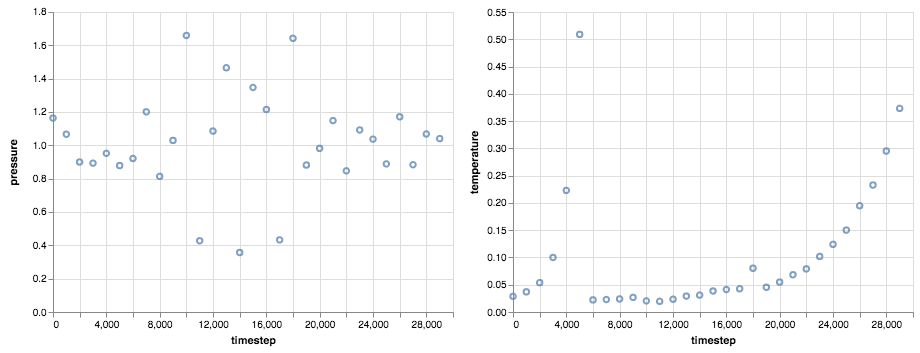

In [16]:
c = alt.Chart(thermo).mark_point().encode(
    x='timestep',
) 
c.encode(y='pressure') | c.encode(y="temperature")

The pressure and temperauter of the final set of configurations. The values for the first 6000 steps are for the simulations with the imaginary mases *tau* of 10, while the remaining values are for the previous simulations with the higher values of *tau* = 50. From these figures, I suspect that varying the temperature is not going to provide useful results.